<a href="https://colab.research.google.com/github/recozers/TCAV/blob/main/TCAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical hypothesis testing in neural networks

Leapoards and Cheetahs look very similar. Theyre both big cats with spots, and as a result many people confuse the two. The best way to tell them apart is the 'tear' marks on Cheetah's.

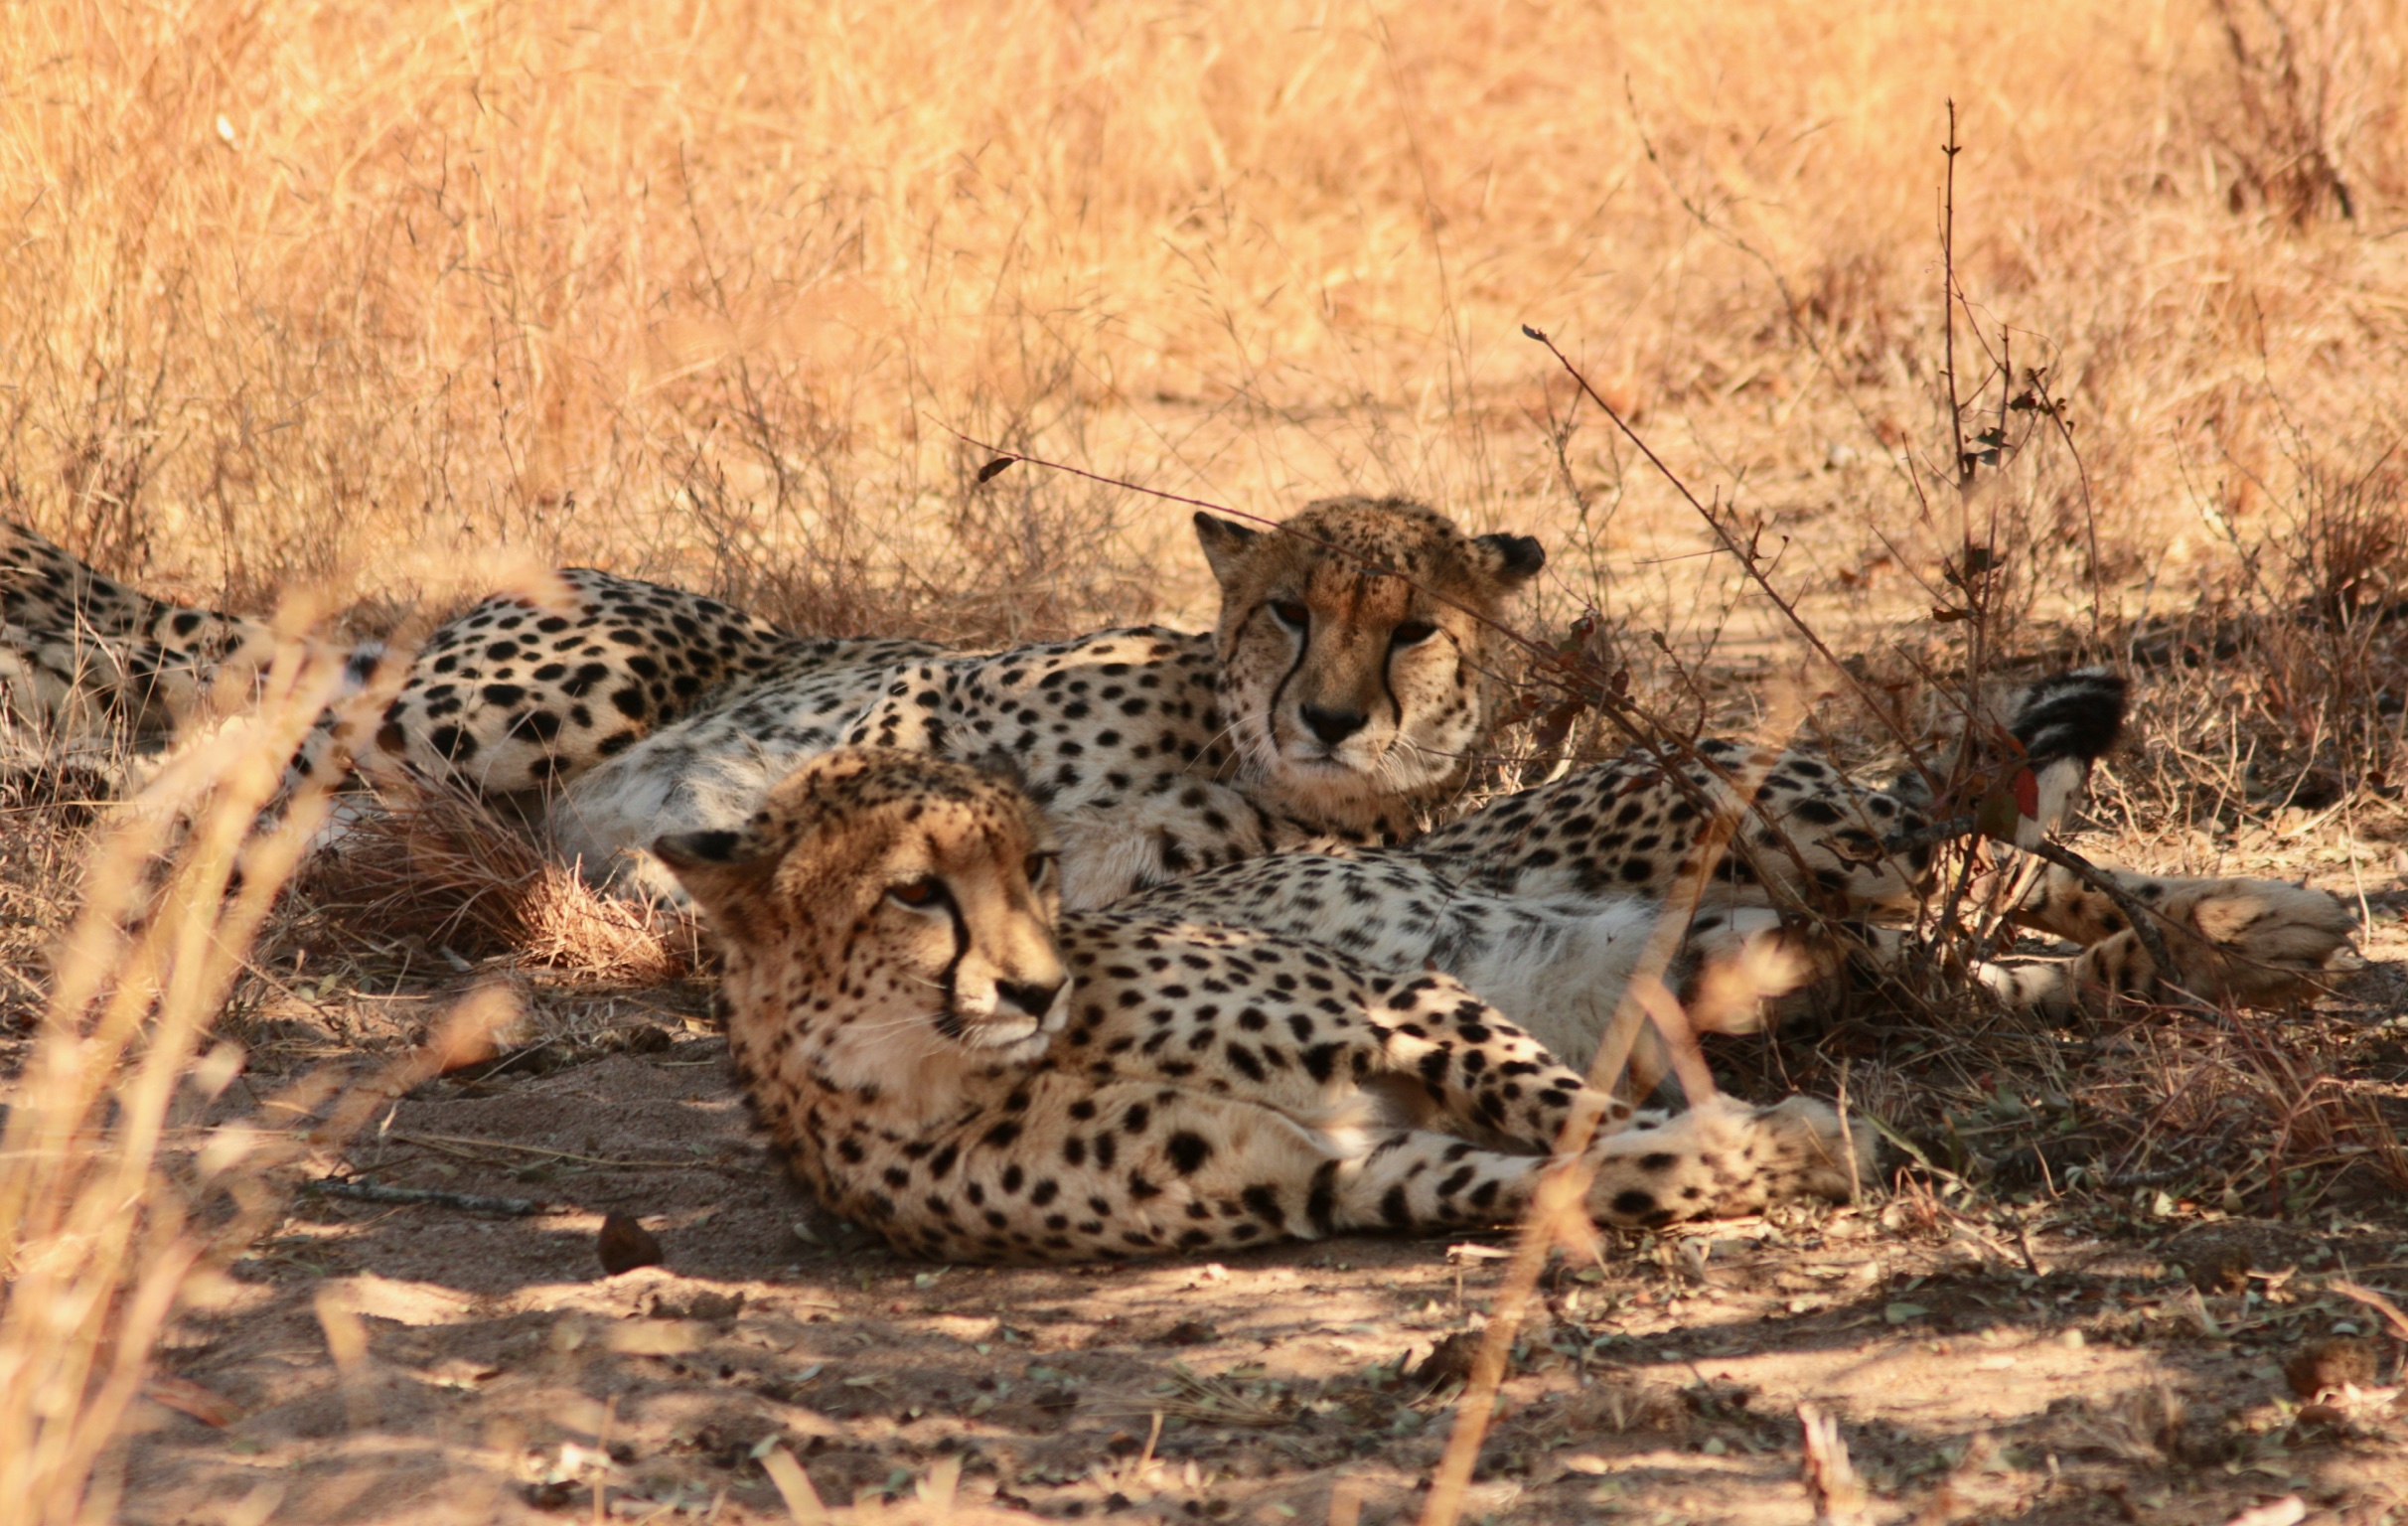

Here's two Cheetah's, you can see they have these really elegeant stripes from their eyes down that look a little bit like tear marks.

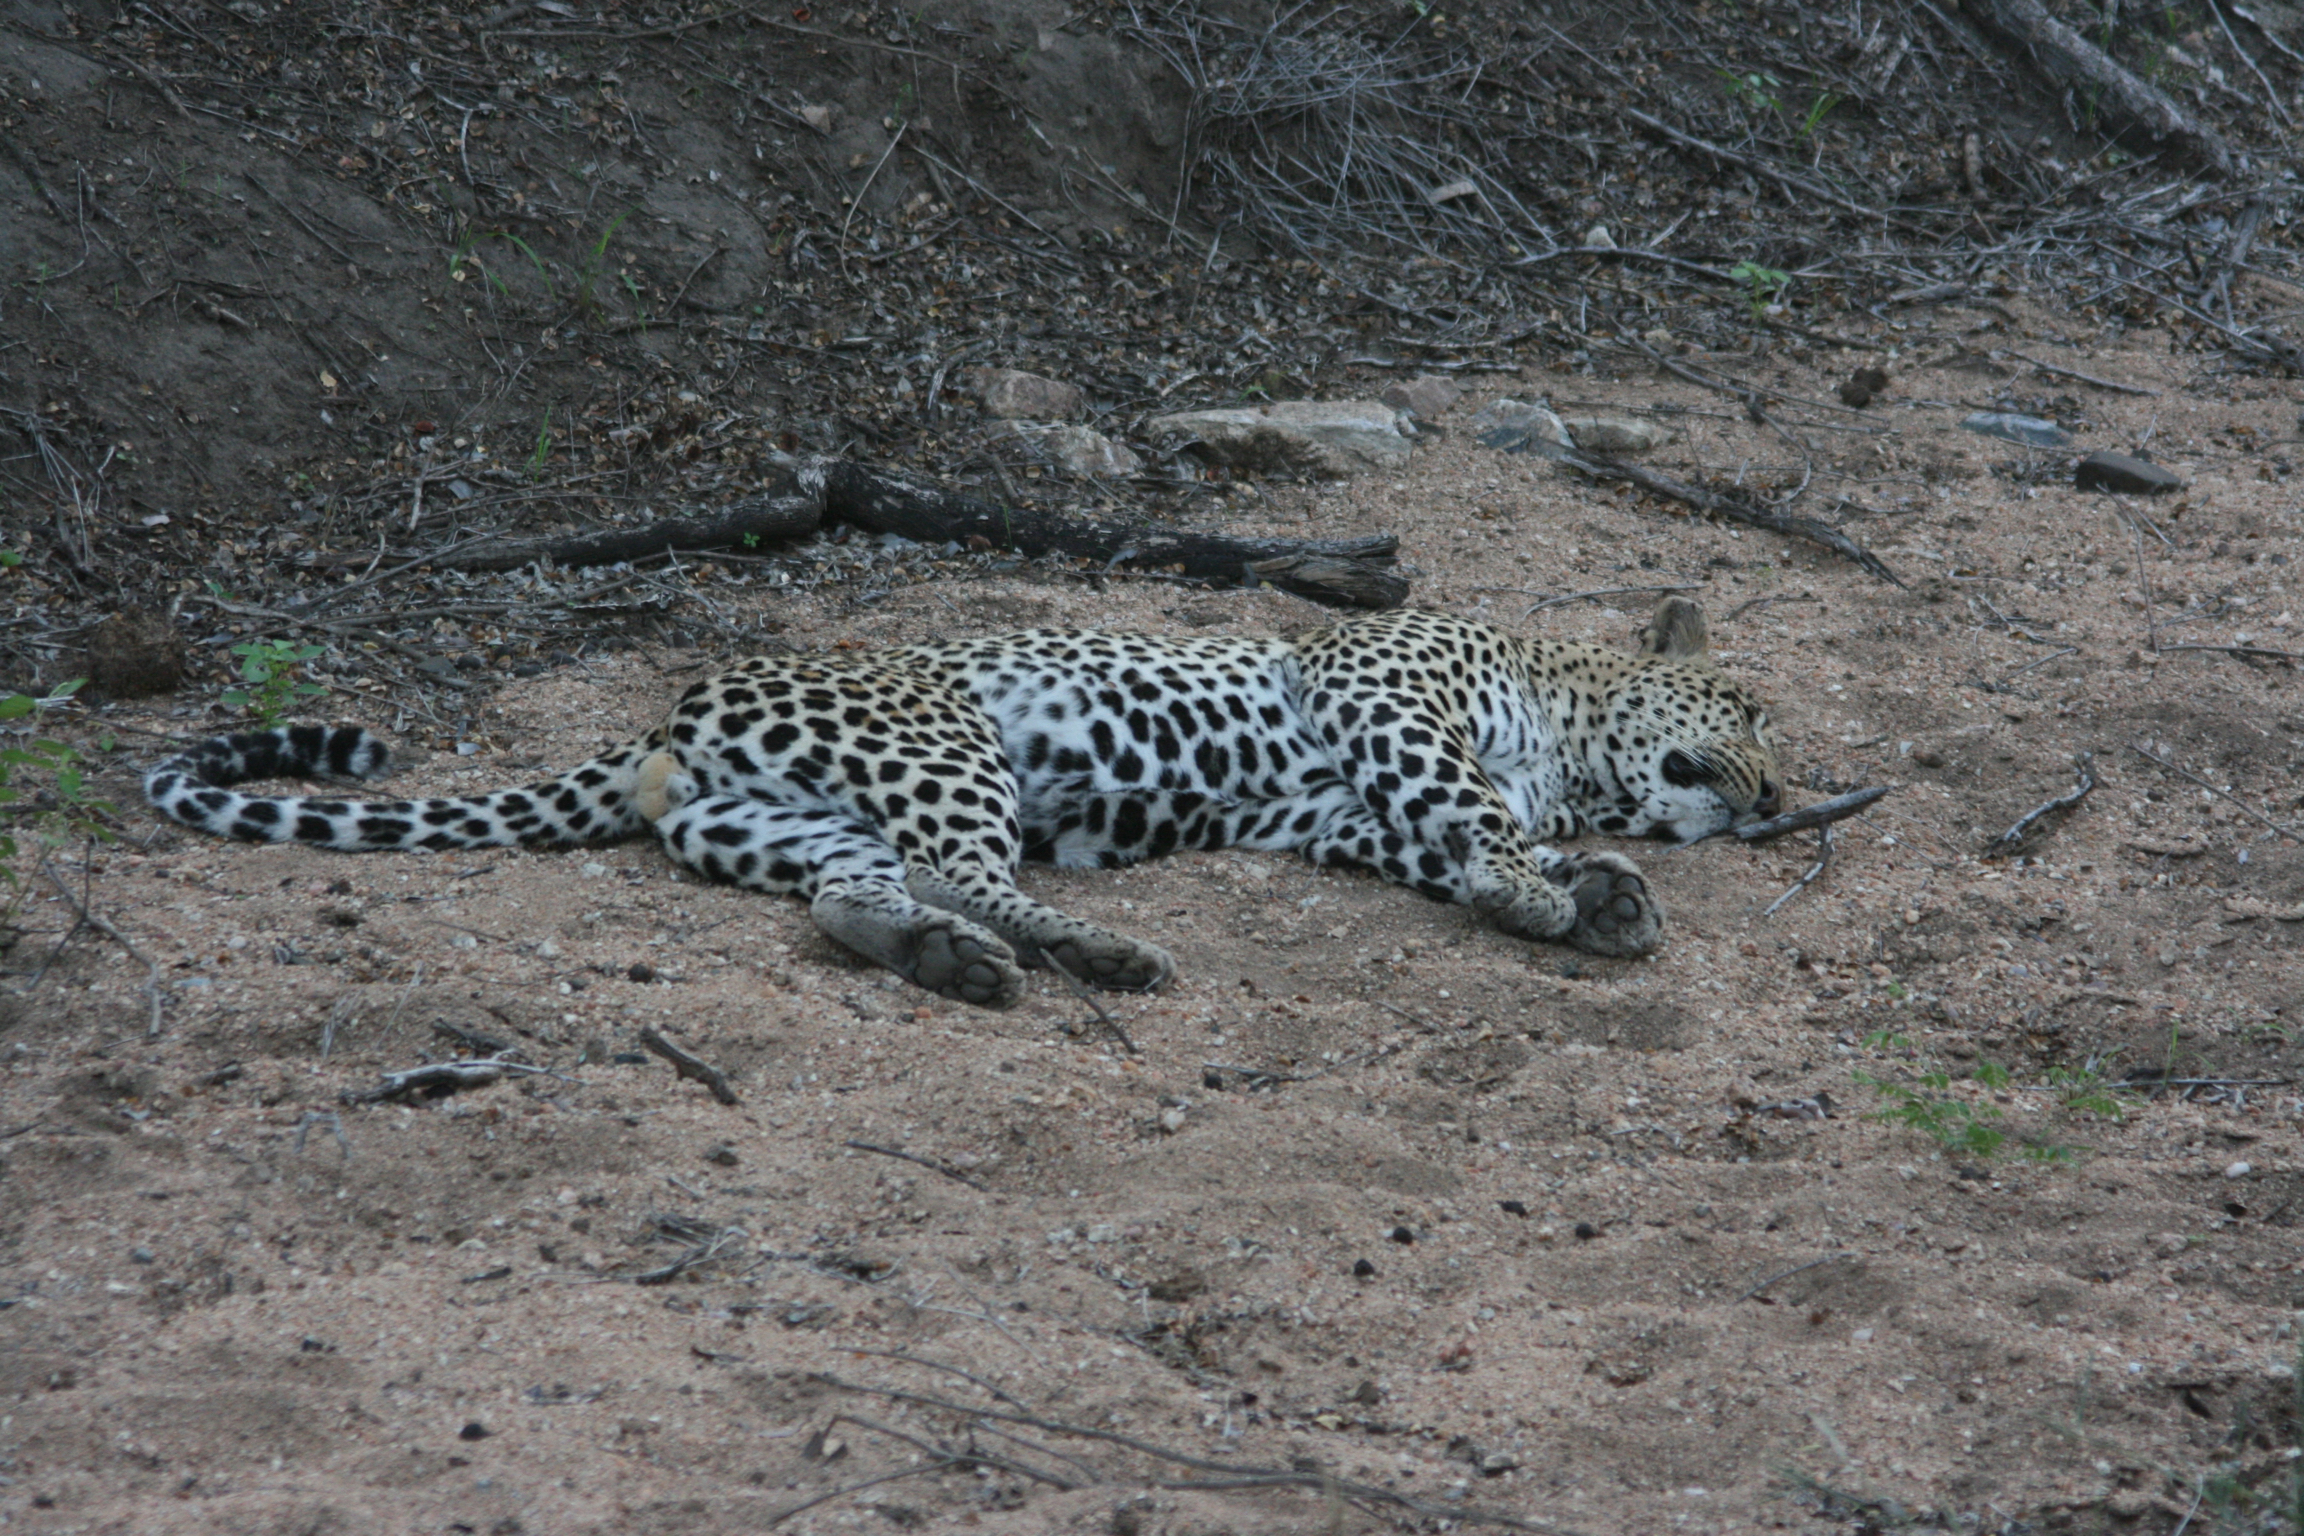

This is what a Leopard looks like by contrast (Don't worry, only sleeping!). You can see that by contrast these marks are not present. There are also differences in spots, but the most obvious difference is those marks.

Now even though we term them 'tear marks' they're not actually tears, nor do they really look anything like tears in the direct sense. So what they really look like in the most direct sense are stripes. Therefore the hypothesis we will be testing is whether the model uses the concept of 'stripes' to identify Cheetah's. H0 is that the concept of stripes is not used. and H1 is the concept of stripes is used. My prediction is that the concept will not be used.

In [ ]:
# Lets start by cloning the TCAV repo
!git clone https://github.com/tensorflow/tcav.git

fatal: destination path 'tcav' already exists and is not an empty directory.


In [ ]:
!pip install tcav

We're going to make use of this code from the example [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb). I manually changed the code to 'Cheetah' and took out 'zigzagged'. You may have to redo this when you clone the repo. Also this takes really long to run.

In [29]:
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=YOUR_FOLDER --number_of_images_per_folder=20 --number_of_random_folders=10

%cd /content/tcav

/content/tcav/tcav/tcav_examples/image_models/imagenet
Downloaded 20 for cheetah
Successfully created data at YOUR_FOLDER
/content/tcav


<Figure size 640x480 with 0 Axes>

Lets load all the necessary libraries

In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tcav.model import KerasModelWrapper
from tcav.tcav import TCAV
import tcav.utils as utils
import logging

# Suppress TensorFlow warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Define all the releveant pathways, much of this code was adapted from this [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb).

In [31]:
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
working_dir = '/content/tcav/tcav'
activation_dir =  working_dir+ '/activations/'

# Provide the exact paths for the concept folders
concepts_paths = {
    'dotted': '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/dotted',
    'striped': '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/striped'  # Adjust as needed
}

# Random concept folders
random_folders = ['/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/random500_0',
                  '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/random500_1']

# Define the target class folder
target = 'cheetah'
target_dir = os.path.join(source_dir, target)
cav_dir = os.path.join(source_dir, 'cavs')

# Create necessary directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

Now lets make a function that will help us load and preprocess the images

In [32]:
def load_images_from_folder(folder_path, target_size=(299, 299)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img)
                img = tf.keras.applications.inception_v3.preprocess_input(img)
                images.append(img)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

Now we can load some images into a concept images dictionary

In [33]:
concept_images = {}
for concept, concept_path in concepts_paths.items():
    if os.path.exists(concept_path):
        images = load_images_from_folder(concept_path)
        concept_images[concept] = images
        print(f"Loaded {images.shape[0]} images for concept '{concept}'.")
    else:
        print(f"Concept folder '{concept}' does not exist at '{concept_path}'.")


Loaded 20 images for concept 'dotted'.
Loaded 20 images for concept 'striped'.


Lets do the same for some random images

In [34]:
random_images = []
for random_folder in random_folders:
    if os.path.exists(random_folder):
        images = load_images_from_folder(random_folder)
        random_images.append(images)
        print(f"Loaded {images.shape[0]} images from random concept folder '{random_folder}'.")
    else:
        print(f"Random concept folder '{random_folder}' does not exist.")
random_images = np.concatenate(random_images, axis=0)

Loaded 25 images from random concept folder '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/random500_0'.
Loaded 23 images from random concept folder '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/random500_1'.


And finally for the target class (Cheetah)

In [35]:
if os.path.exists(target_dir):
    target_images = load_images_from_folder(target_dir)
    print(f"Loaded {target_images.shape[0]} images for target class '{target}'.")
else:
    print(f"Target class folder for '{target}' does not exist at '{target_dir}'.")


Loaded 18 images for target class 'cheetah'.


This code was lifted directly from this [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb). It allows us to have a sanity check and make sure our images are in the right place.

In [36]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

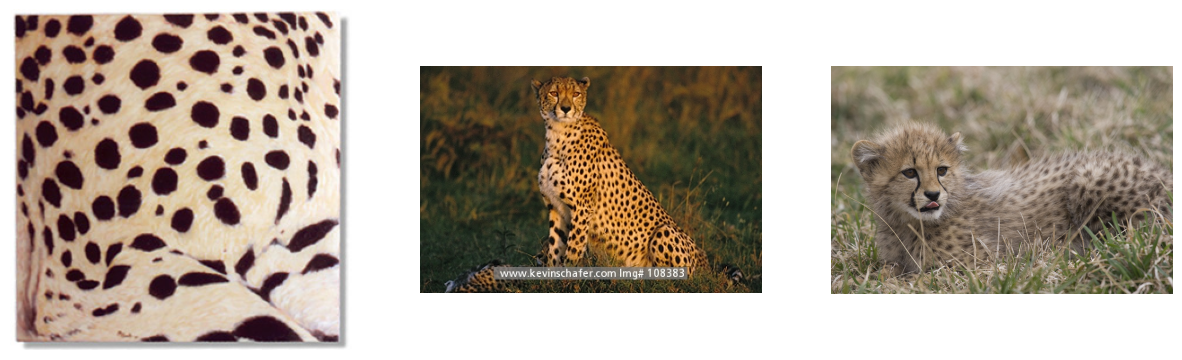

In [37]:
display_random_images(target_dir,3)

Here are some of the images in the cheetah class

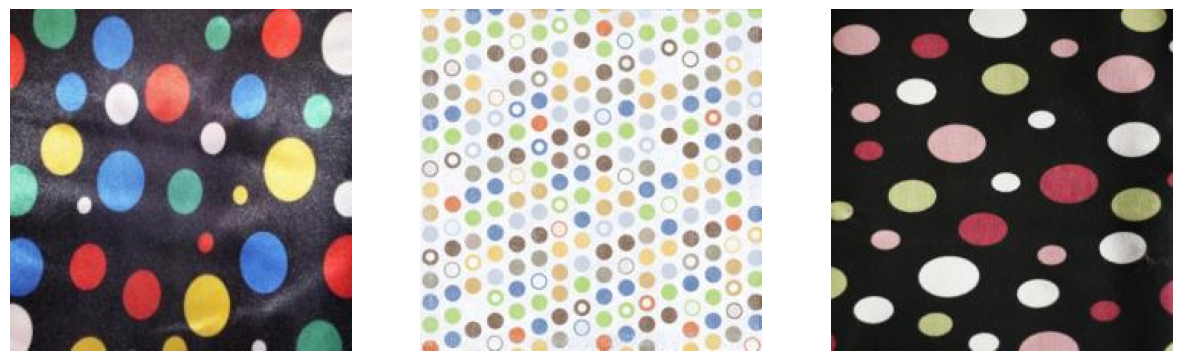

In [38]:
display_random_images(concepts_paths['dotted'],3)

Here are some of the images from the dotted folder

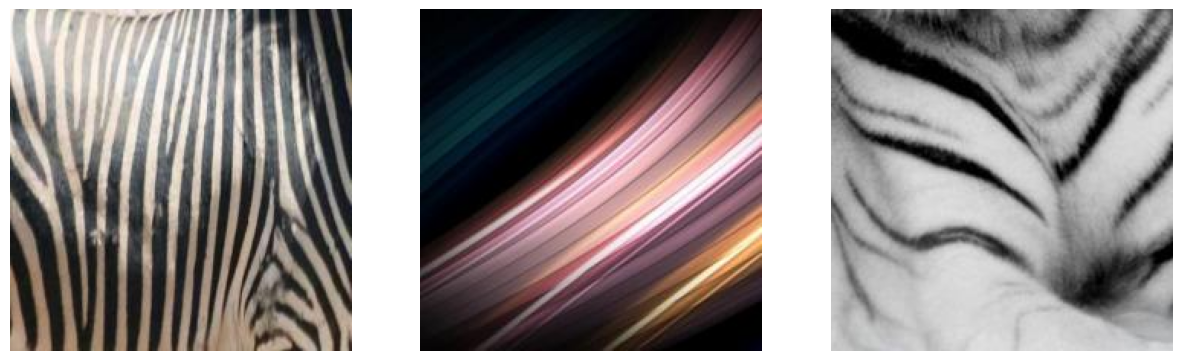

In [39]:
display_random_images(concepts_paths['striped'],3)

Here are some of the images from the striped folder

So now we have all the images loaded into the correct folders. Lets go ahead and apply tcav. Load in the model (again taken from [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb).)

In [5]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h': Is a directory


Prepare the model for tcav (from [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb).)

In [40]:
import tcav.model as model

sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


In [41]:
import tcav.activation_generator as act_gen

act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

adapted from [notebook](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb).

In [44]:
import absl
import tcav.tcav as tcav

absl.logging.set_verbosity(0)
num_random_exp=10 # Recommend >10
mytcav = tcav.TCAV(sess,
                   target='cheetah',
                   concepts=['dotted','striped'],
                   bottlenecks=['mixed4c'],
                   activation_generator=act_generator,
                   alphas=[0.1],
                   cav_dir=cav_dir,
                   num_random_exp=10)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started
Completed


Class = cheetah
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.77 (+- 0.17), random was 0.52 (+- 0.25). p-val = 0.003 (significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.36 (+- 0.25), random was 0.52 (+- 0.25). p-val = 0.053 (not significant)
{'mixed4c': {'bn_vals': [0.7666666666666666, 0.01], 'bn_stds': [0.16814162167135063, 0], 'significant': [True, False]}}


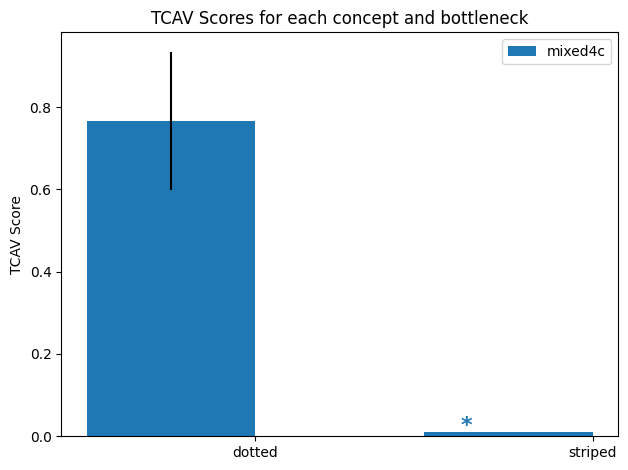

In [45]:
import tcav.utils_plot as utils_plot
utils_plot.plot_results(results, num_random_exp=10)

There is not enough evidence to reject the null hypothesis. The concept of 'dotted' is almost certainly used to identify Cheetah's. So, the mystery of how this model identifies chettah's compared to leopards continues...

# Citations

I obviously used the example notebook that I linked very heavily. I Found the tcav package quite difficult to work with so thats why I stuck so closely to the sample code.

I also consulted with ChatGPT o1-preview when I encountered stubborn errors. To be completely honest it wasn't very helpful but there are some bit of code from it such as the 'load images from folder' function.